In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from msslib.utils import *

import random

from pystruct.models import ChainCRF
import pystruct.learners as ssvm
from pystruct.utils import SaveLogger

from sklearn.decomposition import PCA

import datetime
import random

In [3]:
test_runs = ["A","B","C","D","E","F"]

In [4]:
unwanted_recto = ["VA223RN","VA327RN","VA001RN","VA002RN","VA006RN","VA007RN","VA008RN","VA009RN"]

def get_set_paths(directory):
    return sorted(list(filter(lambda x: "RN" in x and not any(s in x for s in unwanted_recto) , listpaths(directory))))

In [5]:
label_dir = "/home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/"
data_dir = "/home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/data/"    

label_paths = get_set_paths(label_dir)
data_paths = get_set_paths(data_dir)

path_pairs = list(zip(label_paths, data_paths))
print(len(path_pairs))

150


In [6]:
for letter in test_runs:
    split_at = 20
    random.shuffle(path_pairs)
    train = path_pairs[:split_at]
    test = path_pairs[split_at:]
    
    oot_path = os.path.join("/home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/PCA_20_Chain_CRF", letter)
    mkdir(oot_path)
 
    crf = ChainCRF()
    clf = ssvm.OneSlackSSVM(model=crf,n_jobs=-1, C=100, inference_cache=100, tol=.1,
                           logger=SaveLogger(oot_path+'.pickle', save_every=100))
    
    pca = PCA(n_components=20)
    print(datetime.datetime.now())
    print("Training PCA %s" %letter)
    for l, d in train:
        X = flatten_vector_matrix(np.load(d))
        #y = np.squeeze(flatten_vector_matrix(np.load(l)))
        pca.fit(X)
  
    print("Training %s" %letter)
    train_X = []
    train_y = []
    for l, d in train:
        print("Training on %s" %l)
        train_X.append(pca.transform(flatten_vector_matrix(np.load(d))))
        train_y.append(np.squeeze(np.load(l)).flatten().astype('int'))
    print(np.array(train_X).shape)
    clf.fit(train_X, train_y)
        
    print("Testing %s" %letter)
    test_results = []
    for l, d in test:
        X = pca.transform(flatten_vector_matrix(np.load(d)))
        pred = np.asarray(clf.predict([X]))
        test_results.append({
            'name': only_basename(l),
            'pred': pred.reshape(120,90),
            })
    
    print("Saving %s" %letter)
    for result in test_results:
        path = format_path(oot_path, 'npy', result['name'])
        np.save(path, scale_matrix(result['pred'], 10))
    print(datetime.datetime.now())


2016-06-03 14:43:03.595550
Training PCA A
Training A
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA116RN-0288.npy
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA169RN-0340.npy
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA237RN-0238.npy
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA247RN-0418.npy
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA214RN-0215.npy
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA015RN-0016.npy
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA184RN-0355.npy
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA125RN-0126.npy
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA225RN-0396.npy
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA092RN-0093.npy
Training on /home/finlay/HMT/data/VenetusA/1200Hx900W/10blocks/labels/VA261RN

In [18]:
print("Testing %s" %letter)
test_results = []
for l, d in test:
    pre_X = pca.transform(flatten_vector_matrix(np.load(d)))
    X = pre_X.reshape((60,45, pre_X.shape[1]))
    y = np.squeeze(flatten_vector_matrix(np.load(l)))
    pred = np.asarray(clf.predict(X))
    test_results.append({
        'name': only_basename(l),
        'pred': pred.reshape(60,45),
        })
    
print("Saving %s" %letter)
for result in test_results:
    path = format_path(oot_path, 'npy', result['name'])
    np.save(path, scale_matrix(result['pred'], 20))
print(datetime.datetime.now())


Testing A
Saving A
2016-06-03 14:34:23.522664


In [15]:
np.asarray(pred).shape

(60, 45)

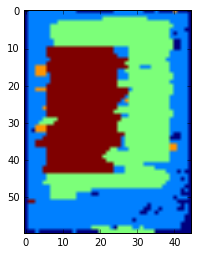

In [16]:
plt.imshow(np.asarray(pred))